# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import sys

from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

import xgboost as xgb

from boruta import BorutaPy

import inflection

from IPython.core.display import Image,display
from IPython.core.display import HTML
import datetime 
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix() 
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr/n ) / min( kcorr-1, rcorr-1 ))

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) /  y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'MODEL NAME' : model_name, 
                           'MAE' : mae, 
                           'MAPE' : mape, 
                           'RMSE' : rmse }, index=[0] )


# makes de cross validation for a given model
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    # creates empty lists to store the metrics
    mae_list = []
    mape_list = []
    rmse_list = []

    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # final date minus 6 weeks
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 7 * 6)

        # final date
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 7 * 6)

        # filters dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m_regression = model.fit(xtraining, ytraining)

        # prediction
        yhat = m_regression.predict(xvalidation)

        # performance
        regression_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # stores the performance of each KFold iteration
        mae_list.append(regression_result['MAE'])
        mape_list.append(regression_result['MAPE'])
        rmse_list.append(regression_result['RMSE'])

    # calculates the mean from the errors : the real metric for the algorithm
    # and creates a DataFrame to organize the data
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                       index=[0])



In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
539973,1099,3,2014-03-05,8546,968,1,1,0,0,a,c,200.0,4.0,2013.0,1,14.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0 Descricao dos Dados

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print( 'number of rows: {}'.format( df1.shape[0] ) )
print( 'number of cols: {}'.format( df1.shape[1] ) )

number of rows: 1017209
number of cols: 18


## 1.3 Data Types

In [10]:
df1[ 'date' ] = pd.to_datetime( df1[ 'date' ] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
# 3 formas de substituir NA
# 1. Jogar Fora
# 2. Substituir (fillna) ou com Machine Learning
# 3. Lógica de Negócio (descobrir na empresa o que gerou o NA e usar essa regra para recuperar os dados)

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
430883,164,2,2014-06-10,5446,626,1,0,0,1,a,a,1160.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [14]:
# Tratando os Dados NA a partir da Lógica de Negócio

# competition_distance  
df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )

# competition_open_since_year 
df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )
                         
# promo2_since_week 
df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )
   
# promo2_since_year 
df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )

# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1[ 'promo_interval' ].fillna( 0, inplace=True )

df1[ 'month_map' ] = df1[ 'date' ].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x[ 'month_map' ] in x[ 'promo_interval' ].split( ',' ) else 0, axis=1 )


In [15]:
# não temos mais NA's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [16]:
df1.sample(5).T

,320106,492300,214432,928863,207232
store,609,256,353,854,958
day_of_week,5,3,2,4,2
date,2014-10-03 00:00:00,2014-04-16 00:00:00,2015-01-20 00:00:00,2013-03-21 00:00:00,2015-01-27 00:00:00
sales,0,12040,5371,7118,4591
customers,0,1463,1463,744,574
open,0,1,1,1,1
promo,1,1,0,1,1
state_holiday,a,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,a,b,c,a


## 1.6 Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
#mudando os tipos de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')  
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [20]:
#Estatística Descritiva serve para 2 coisas:
#1. Ganhar conhecimento de Negócio
#2. Detectar Erros e Anomalias

#Existem 2 grandes métricas na estatística Descritiva
#1. Tendência Central -> Média e Mediana resumem todos os dados em valores únicos
#2. Dispersão -> Variância, Min e Máx, Skew, Kurtosis e Desv.Padrao mostram o quão esparso estão os dados ao redor da média

In [21]:
#Precisamos separar os dados em variáveis numéricas e categóricas

#numéricas
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64' ] )

#categoricas
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]' ] )

cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
796062,0,d,c,0,Jul
780512,0,a,a,0,Aug


### 1.7.1 Numerical Attributes

In [22]:
#tendencia central / central tendency ct
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#dispersao
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skw', 'kurtosis'  ] 

In [23]:
m

,attributes,min,max,range,mean,median,std,skw,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

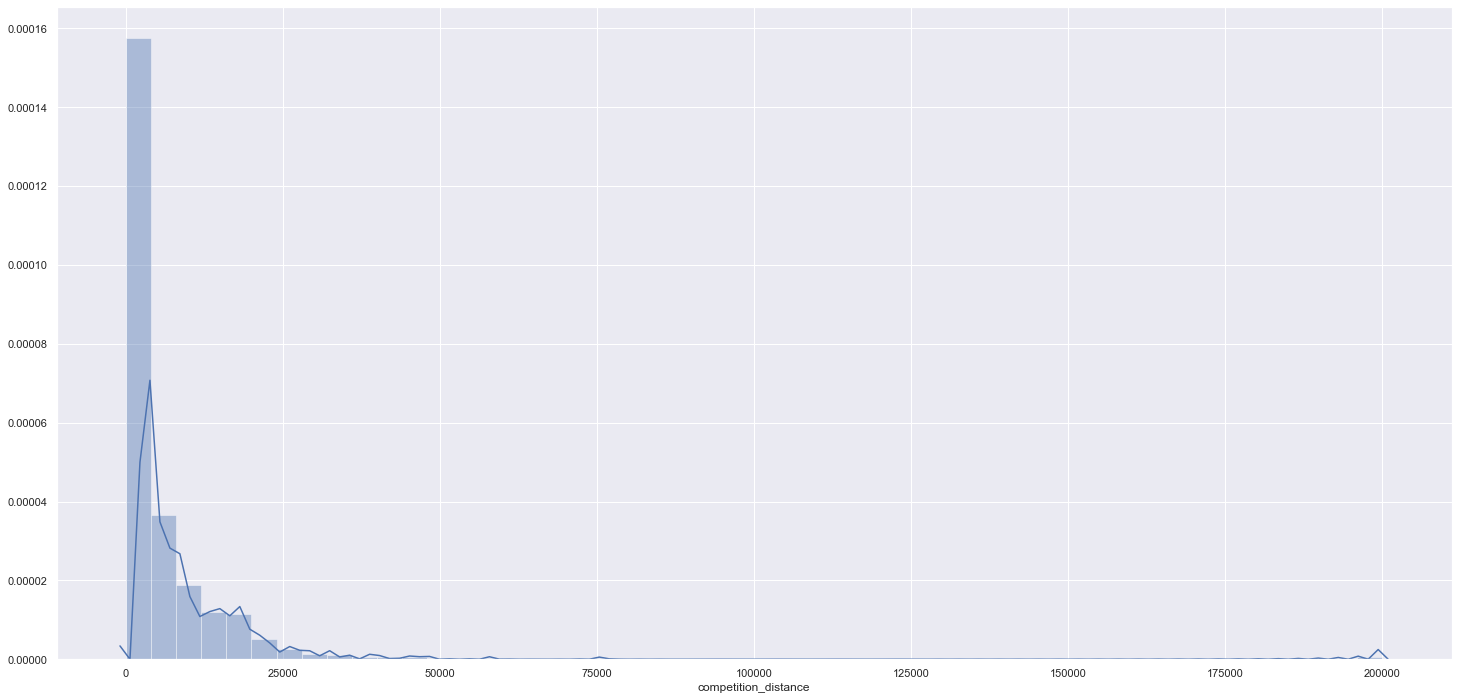

In [24]:
#competition distance tem um elevado skew positivo e kurtosis
#isso mostra que a maioria das lojas competidoras são próximas (distancia) e perto de zero

#media = mediana -> normal
sns.distplot( df1[ 'competition_distance' ] )

### 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

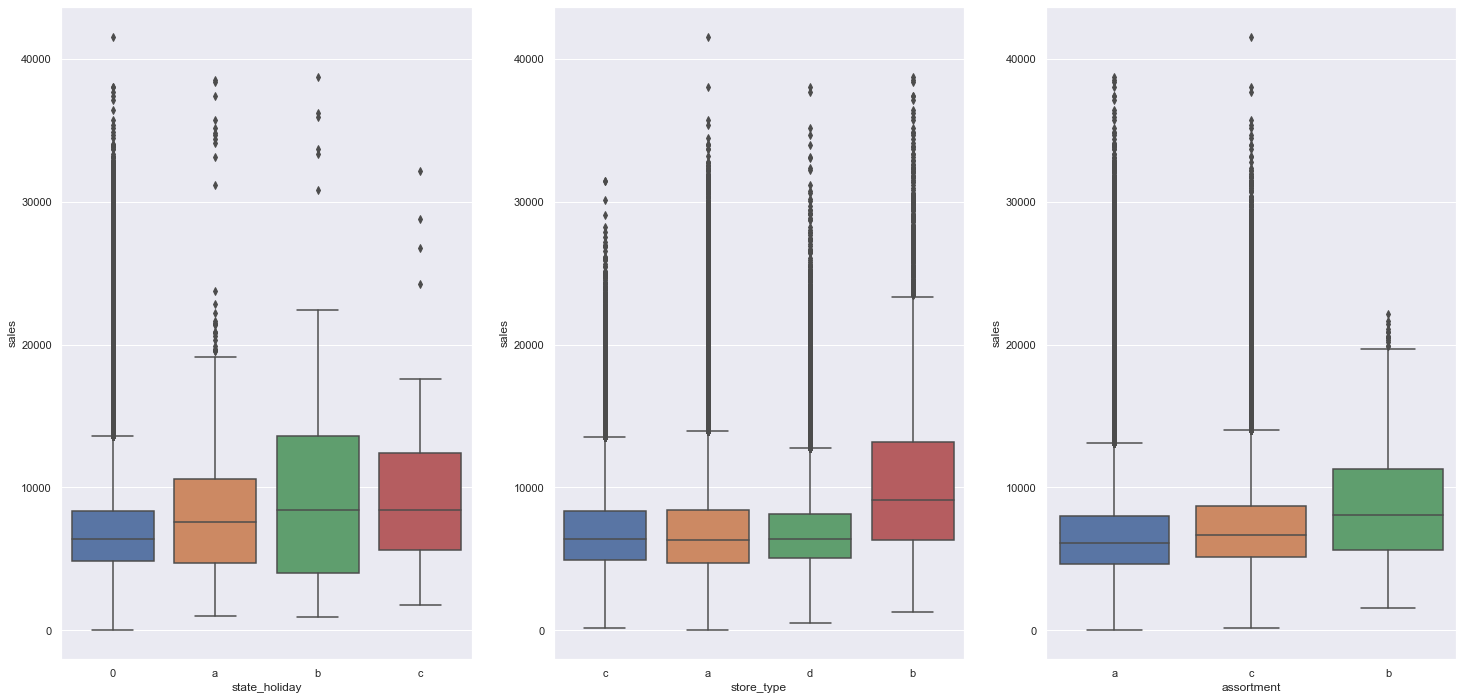

In [26]:
#filtragem
#como as variaveis categorigas são muito dispares, o boxplot fica disperso demais
#filtrando em state_holiday !=0 e sales > 0 reduz o tamanho do gráfico
aux1 = df1[ ( [ 'state_holiday' ] != 0 ) & ( df1[ 'sales' ] > 0 ) ]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 Feature Engineering

In [27]:
df2 = df1.copy()

## Mapa Mental

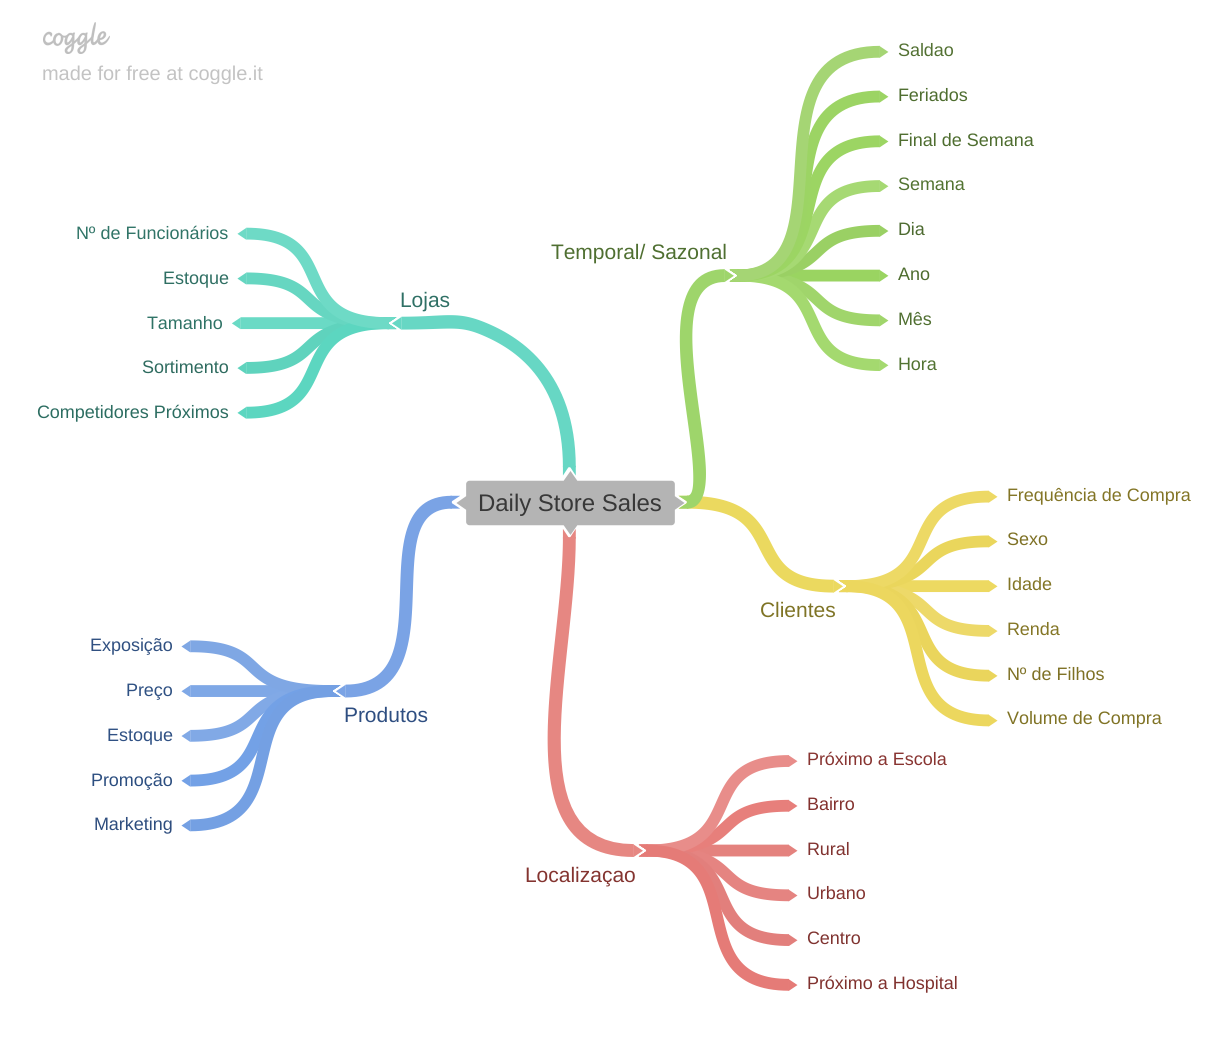

In [28]:
Image('img/mindmap_hypotesis.png')

## 2.1 Criacao das Hipoteses

In [29]:
df2 = df1.copy()

### 2.1.1 Hipoteses Lojas

**1.** Lojas com maior quadro de funcionários vendem/ ou deveriam vender mais

**2.** Lojas com maior estoque vendem/ ou deveriam vender mais

**3.** Lojas com maior porte vendem/ ou deveriam vender mais

**4.** Lojas com menor porte vendem/ ou deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais

### 2.1.3 Hipoteses Tempo

**1.** Lojas que entram mais em feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista Final de Hipoteses (Prioridades)

### Lista

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoçoes ativas a mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoçoes consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**9.** Lojas que abrem nos finais de semana deveriam vender mais

**10.** Lojas deveriam vender mais ao longo dos anos

**11.** Lojas deveriam vender mais no segundo semestre do ano

**12.** Lojas deveriam vender mais depois do dia 10 de cada mes

**13.** Lojas deveriam vender menos aos finais de semana

**14.** Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering

In [30]:

# variáveis à derivar:

# year
df2[ 'year' ] = df2[ 'date' ].dt.year

# month 
df2[ 'month' ] = df2[ 'date' ].dt.month

# day
df2[ 'day' ] = df2[ 'date' ].dt.day

# week of year
df2[ 'week_of_year' ] = df2[ 'date' ].dt.weekofyear

# year week
df2[ 'year_week' ] = df2[ 'date' ].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime(year=x[ 'competition_open_since_year' ], month=x[ 'competition_open_since_month' ], day=1), axis=1 )
df2[ 'competition_time_month' ] = ( ( df2[ 'date' ] - df2[ 'competition_since' ] ) / 30 ).apply( lambda x: x.days).astype( 'int64' )

# promo since
df2[ 'promo_since' ] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2[ 'promo2_since_week' ].astype( str )
df2[ 'promo_since' ] = df2[ 'promo_since' ].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2[ 'promo_time_week' ] = ( ( df2[ 'date' ] - df2[ 'promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2[ 'assortment' ] = df2[ 'assortment' ].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2[ 'state_holiday' ] = df2[ 'state_holiday' ].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [31]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [32]:
df3 = df3[ ( df3[ 'open' ] != 0 ) & ( df3[ 'sales' ] > 0 ) ]

## 3.2 Selecao de Colunas

In [33]:
drop_cols = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( drop_cols, axis=1 )

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria de Dados

In [35]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

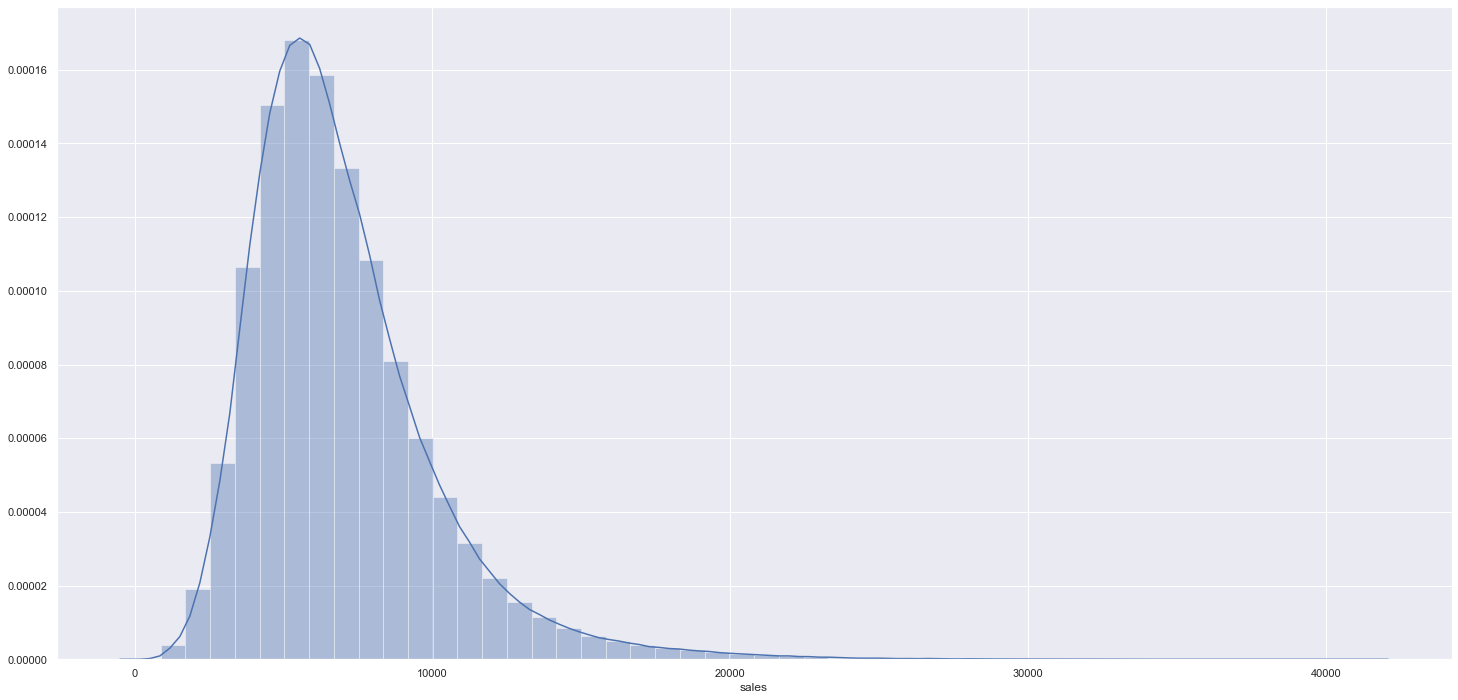

In [36]:
sns.distplot( df4[ 'sales' ] )

### 4.1.2 Numerical Variable

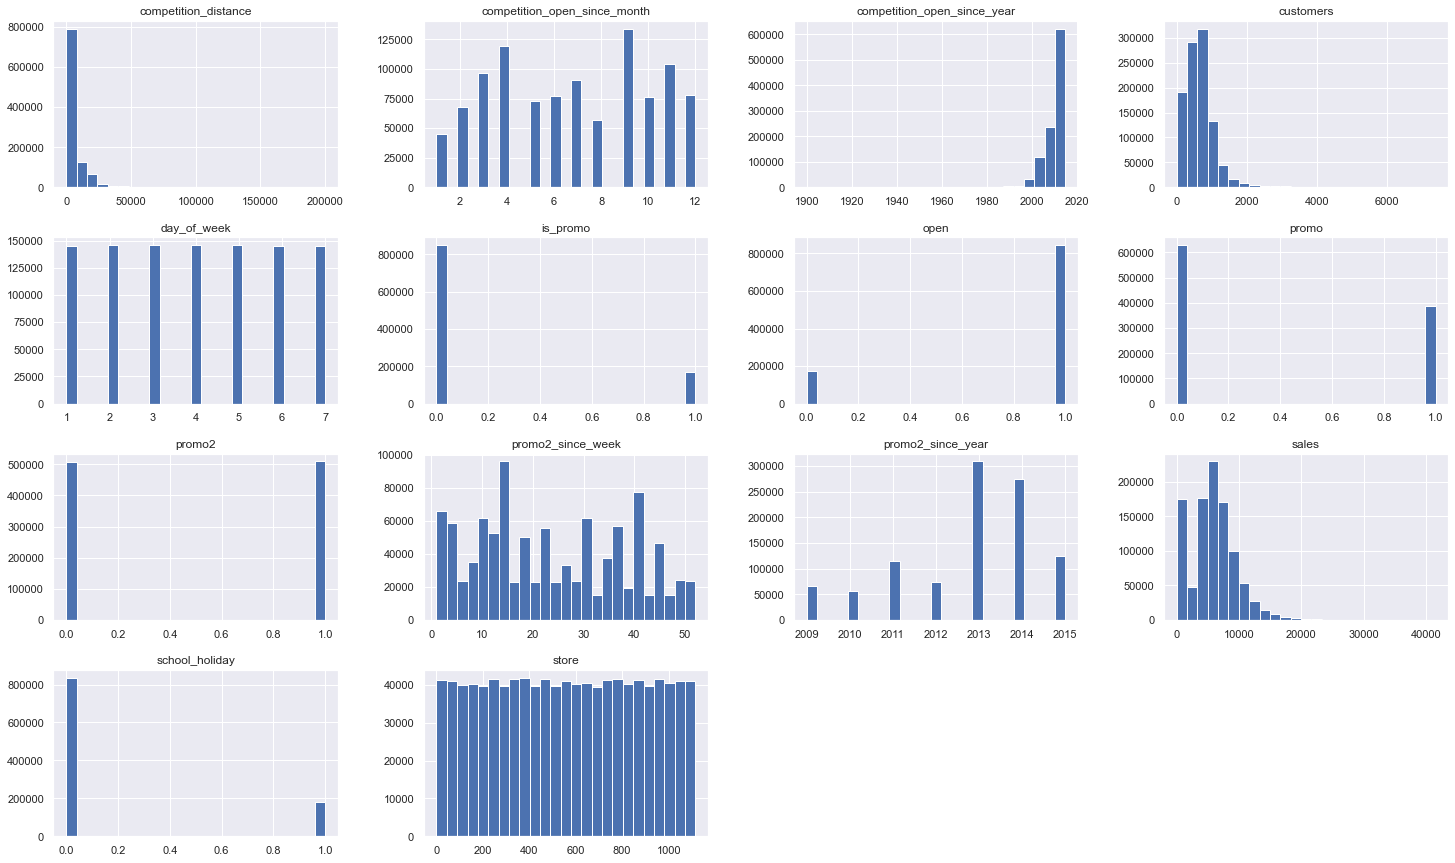

In [37]:
num_attributes.hist( bins=25, figsize=(25,15) );

### 4.1.3 Categorical Variable

In [38]:
df4[ 'assortment' ].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:>

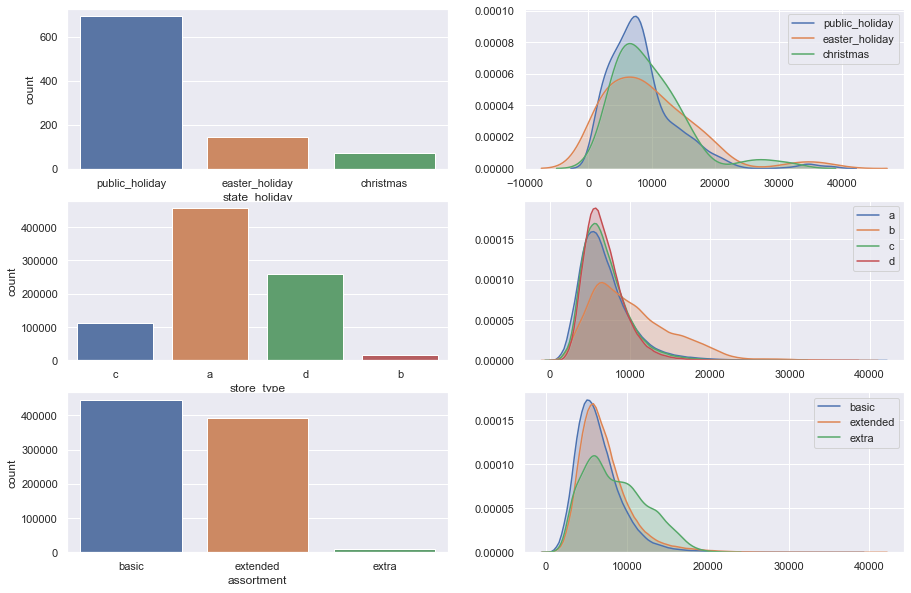

In [39]:
# state_holiday
f = plt.figure( figsize=(15,10) )

f.add_subplot( 321 )
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( a[ 'state_holiday' ] )

f.add_subplot( 322 )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ]['sales'], label='public_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ]['sales'], label='easter_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ]['sales'], label='christmas', shade=True  )

# store_type

f.add_subplot( 323 )
sns.countplot( df4[ 'store_type' ] )

f.add_subplot( 324 )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ]['sales'], label='a', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ]['sales'], label='b', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ]['sales'], label='c', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ]['sales'], label='d', shade=True  )

# assortment
f.add_subplot( 325 )
sns.countplot( df4[ 'assortment' ] )

f.add_subplot( 326 )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ]['sales'], label='basic', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ]['sales'], label='extended', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ]['sales'], label='extra', shade=True  )

## 4.2 Analise Bivariada

#### H1. Lojas com maior sortimento deveriam vender mais
***Falsa*** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

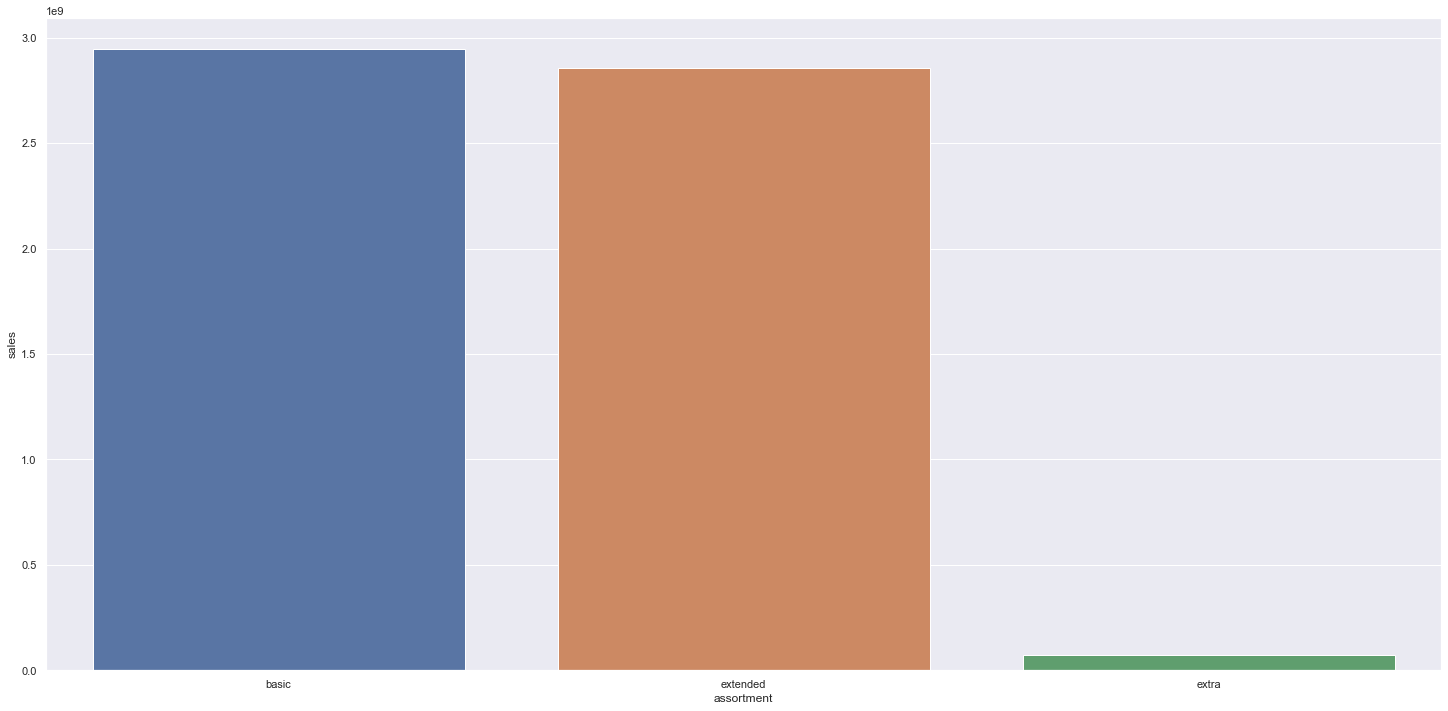

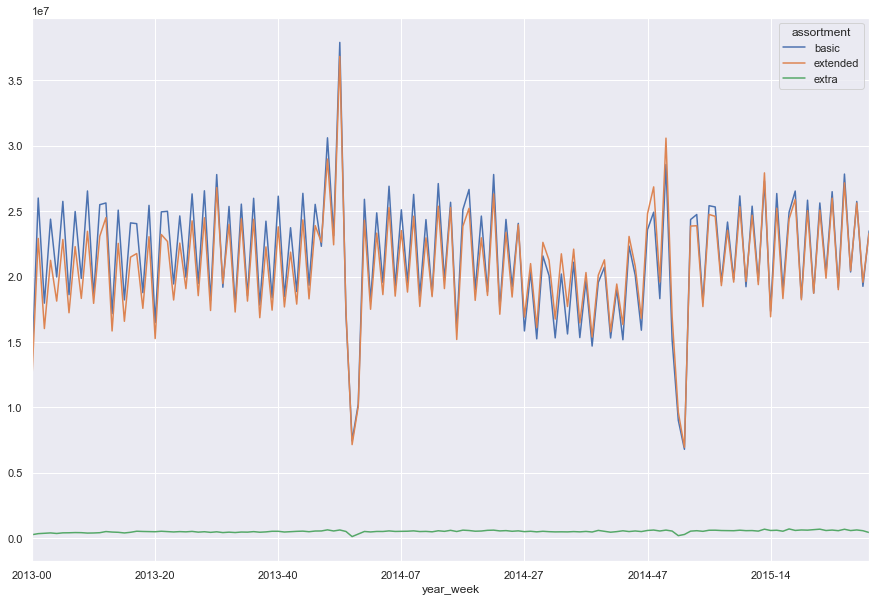

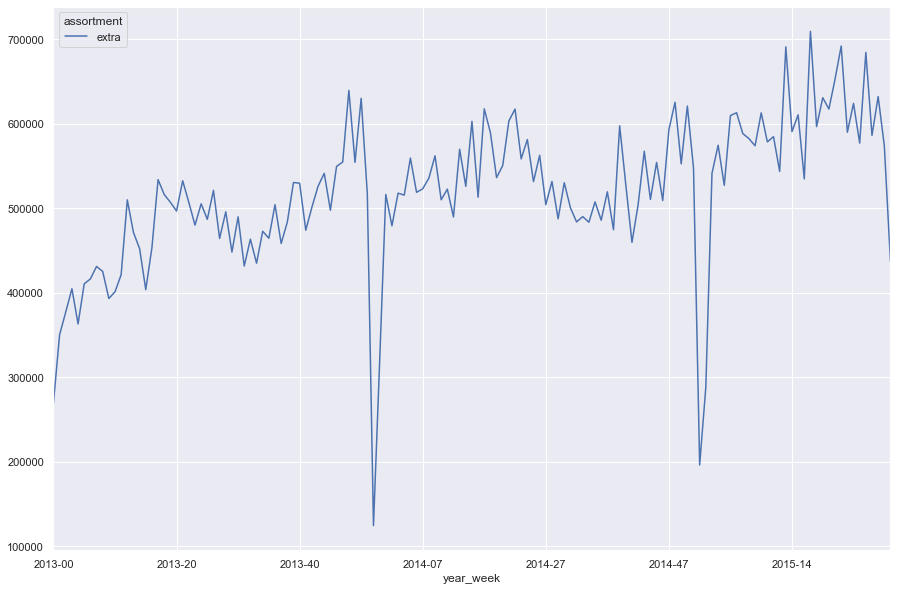

In [40]:
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( ['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

aux3 = aux2[ aux2[ 'assortment' ] == 'extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

#### H2. Lojas com competidores mais próximos deveriam vender menos
***Falsa*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

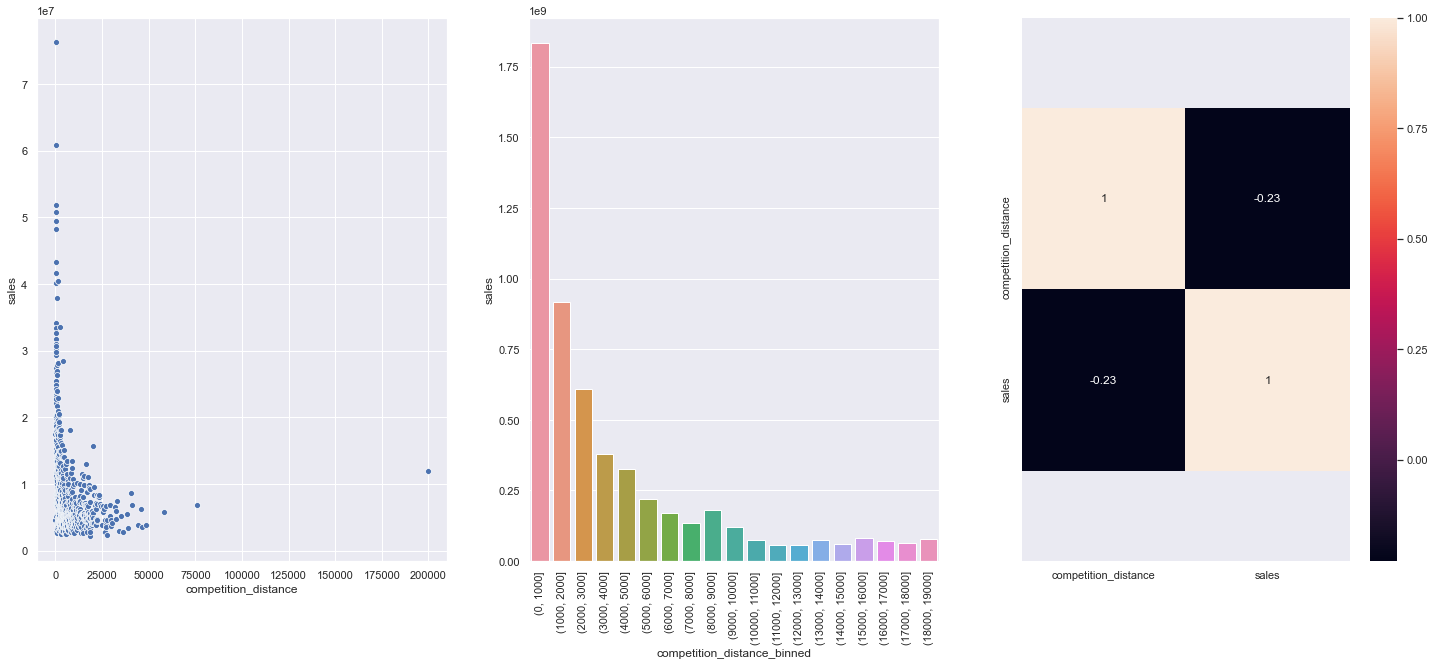

In [41]:
aux1 = df4[ [ 'competition_distance', 'sales' ] ].groupby( 'competition_distance' ).sum().reset_index()

f = plt.figure( figsize=(25,10) )
f.add_subplot( 131 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

bins = list( np.arange( 0, 20000, 1000 ) )

aux1[ 'competition_distance_binned' ] = pd.cut( aux1[ 'competition_distance'], bins=bins )
aux2 = aux1[ [ 'competition_distance_binned', 'sales' ] ].groupby( 'competition_distance_binned' ).sum().reset_index()

f.add_subplot( 132 )
#plt.figure( figsize=(30, 10) )
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

f.add_subplot( 133 )
x = sns.heatmap( aux1.corr( 'pearson' ), annot=True )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### H3. Lojas com competidores a mais tempo deveriam vender mais
***Falsa*** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

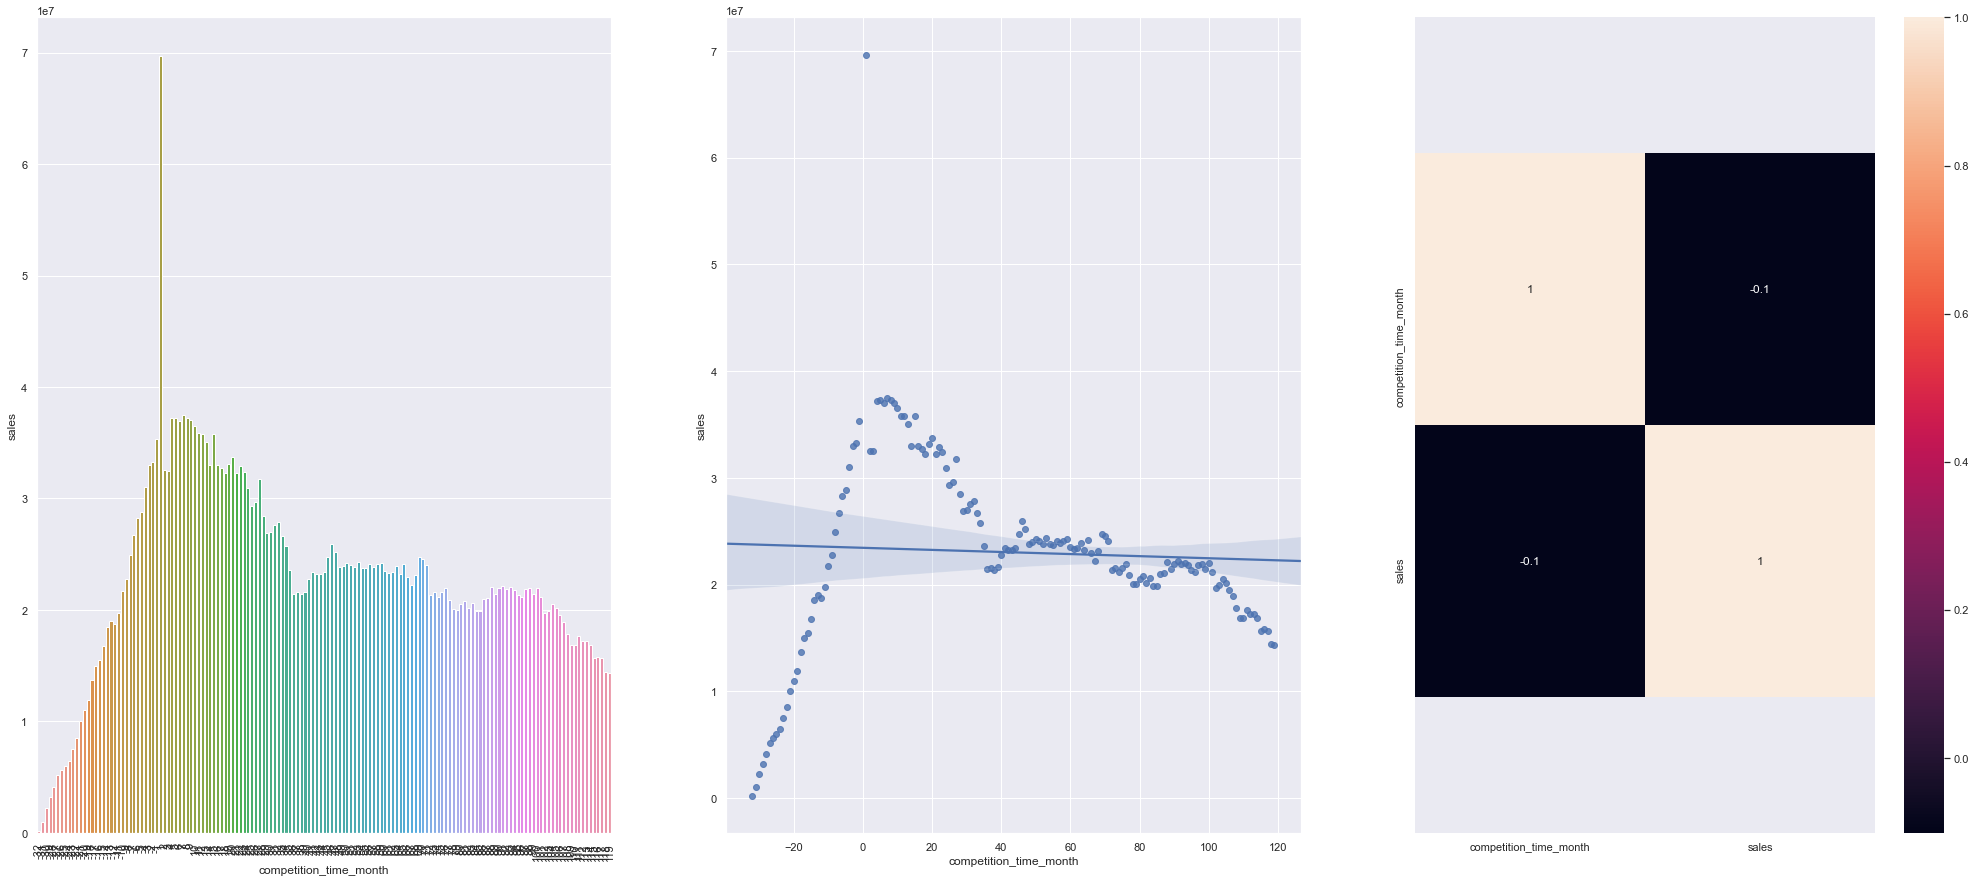

In [42]:
aux1 = df4[ [ 'competition_time_month', 'sales' ] ].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ ( aux1[ 'competition_time_month' ] < 120 ) & ( aux1[ 'competition_time_month' ] != 0 ) ]

plt.figure( figsize=( 35, 15) )
plt.subplot( 1, 3, 1)
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3 ,3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True )
bottom, top = x.get_ylim( )
x.set_ylim( bottom+0.5, top-0.5);

#### H4. Lojas com promoçoes ativas a mais tempo deveriam vender mais
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

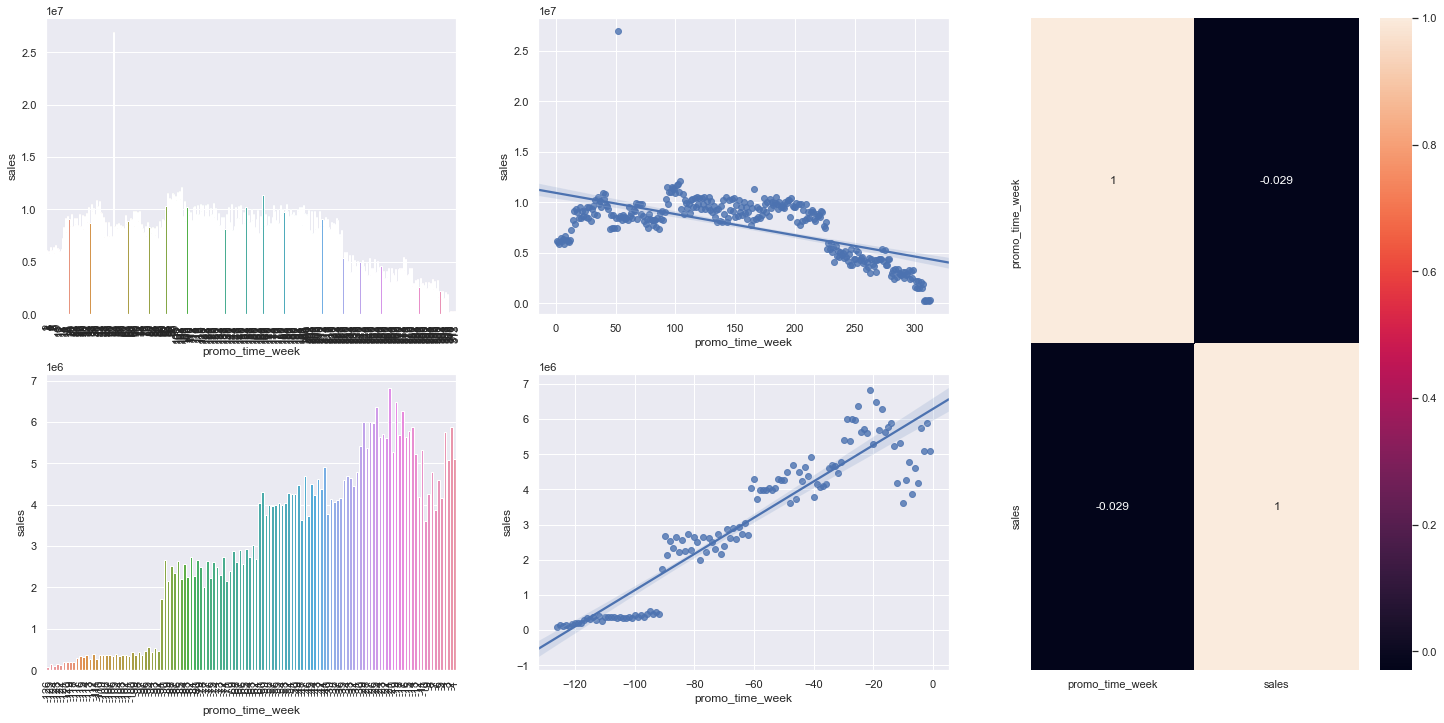

In [43]:
aux1 = df4[[ 'promo_time_week', 'sales' ]].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ] #promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[ aux1[ 'promo_time_week' ] < 0 ] #promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H5. <s> Lojas com mais dias de promoção deveriam vender mais </s>

#### H6. Lojas com mais promoçoes consecutivas deveriam vender mais
***Falsa*** Lojas com mais promoções consecutivas vendem menos

In [44]:
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


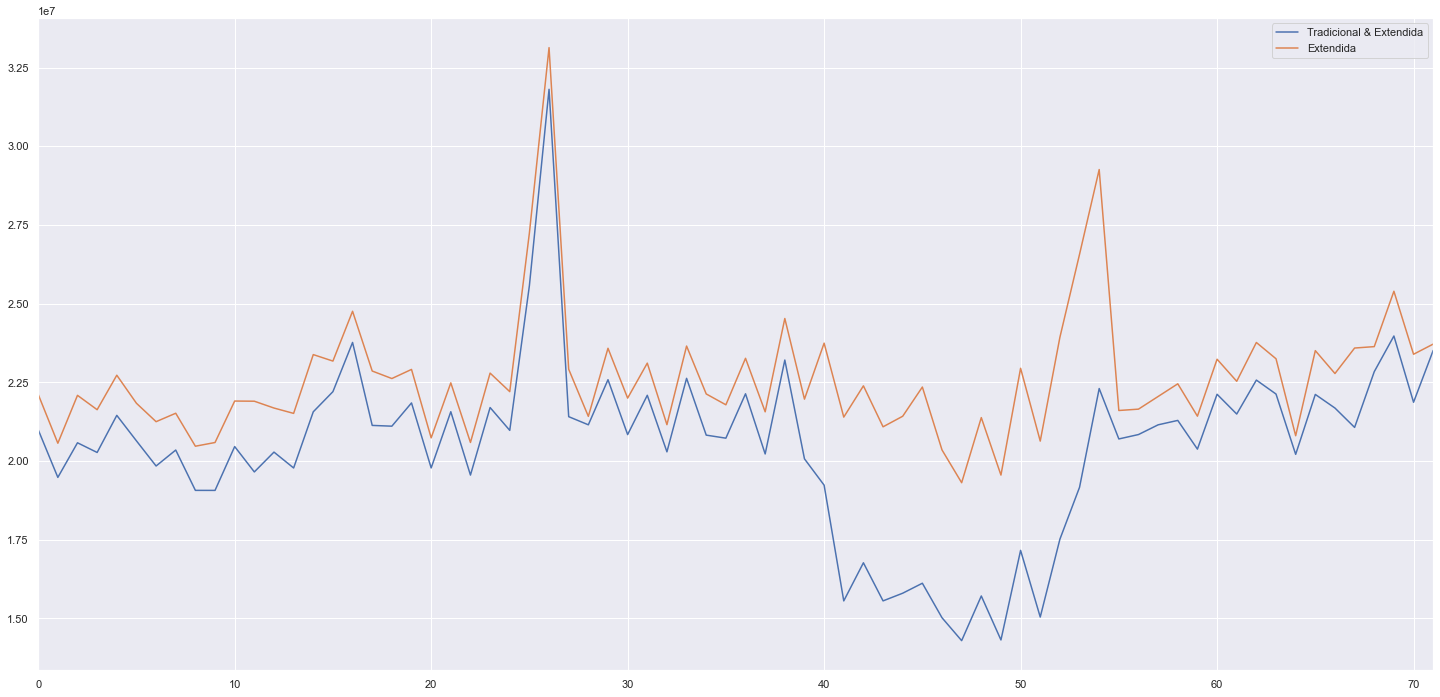

In [45]:
aux1 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 1 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot();

aux2 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 0 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=[ 'Tradicional & Extendida', 'Extendida' ] );

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
***Falsa*** Lojas abertas durante o feriado de Natal vendem menos

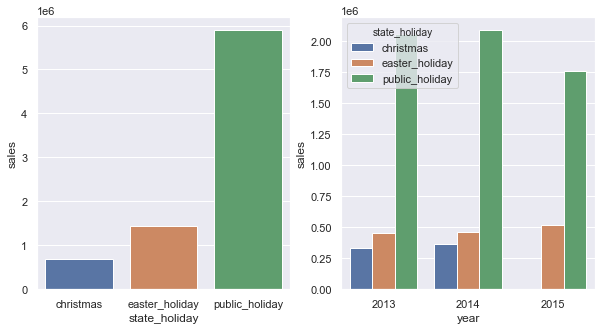

In [46]:
plt.figure( figsize=(10,5) )
plt.subplot( 1, 2, 1 )
aux = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
aux1 = aux[[ 'state_holiday', 'sales' ]].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[[ 'year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### H8. Lojas deveriam vender mais ao longo dos anos
***Falsa*** Lojas vendem menos ao longo dos anos


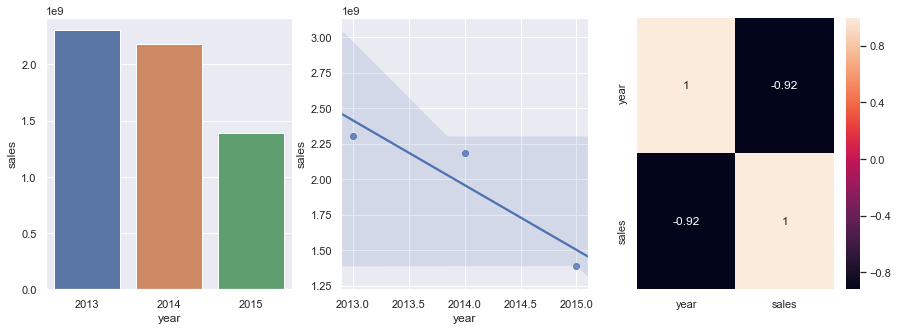

In [47]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H11. Lojas deveriam vender mais no segundo semestre do ano
***Falsa*** Lojas vendem menos no segundo semestre do ano

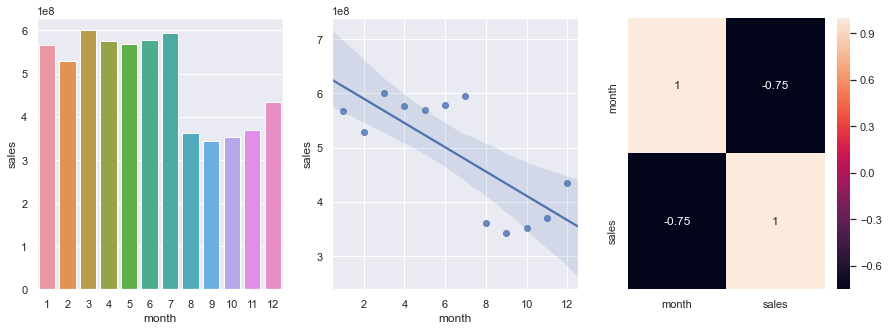

In [48]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H12. Lojas deveriam vender mais depois do dia 10 de cada mes
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês

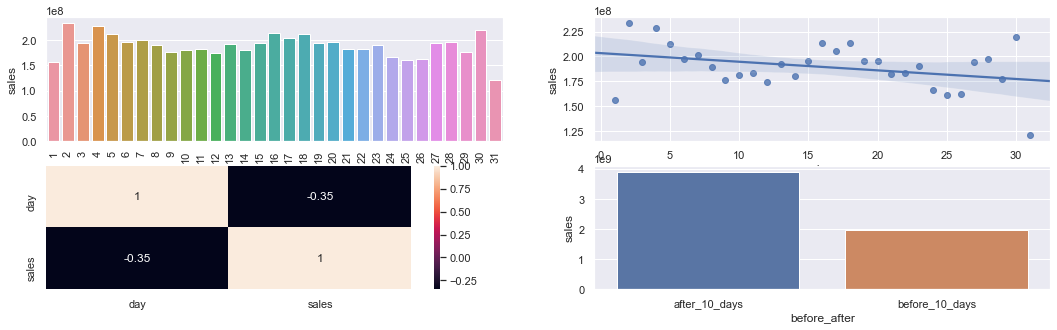

In [49]:
plt.figure( figsize=(18,5) )
plt.subplot( 2, 2, 1 )
aux1 = df4[[ 'day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1 );
plt.xticks( rotation=90 )

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 2, 2, 4 )
aux1[ 'before_after' ] = aux1[ 'day' ].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[[ 'before_after', 'sales' ]].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

#### H13. Lojas deveriam vender menos aos finais de semana
***Verdadeira*** Lojas vendem menos aos fins de semana

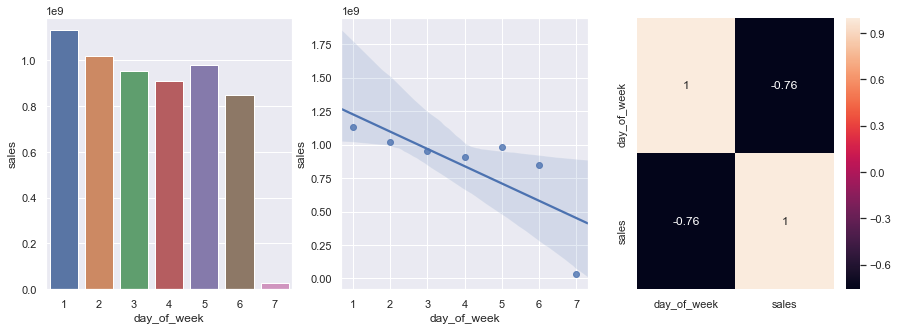

In [50]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H14. Lojas deveriam vender menos durante os feriados escolares
***Verdadeira*** Lojas vendem menos durante os feriados escolares, exceto durante os meses de julho e agosto.

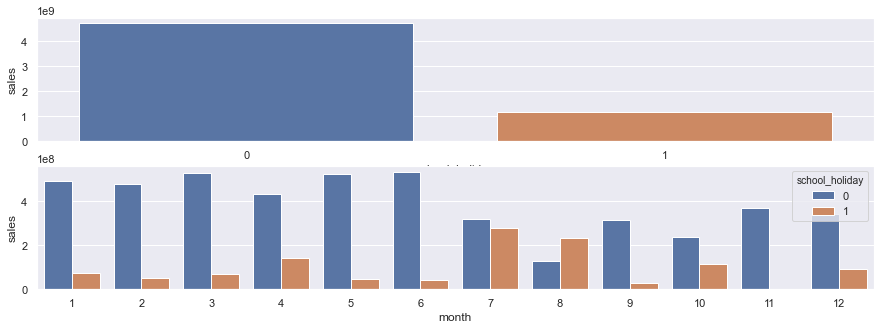

In [51]:
plt.figure( figsize=(15,5) )
plt.subplot( 2, 1, 1 )
aux1 = df4[[ 'school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[[ 'month', 'school_holiday', 'sales' ]].groupby([ 'month', 'school_holiday' ]).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

#### Resumo de Hipóteses

In [52]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '--', '--'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H11', 'Falsa', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Alta'],
       ['H14', 'Verdadeira', 'Baixa']]

print( tabulate( tab, headers='firstrow' ) )

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          --           --
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H11         Falsa        Alta
H12         Verdadeira   Alta
H13         Verdadeira   Alta
H14         Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

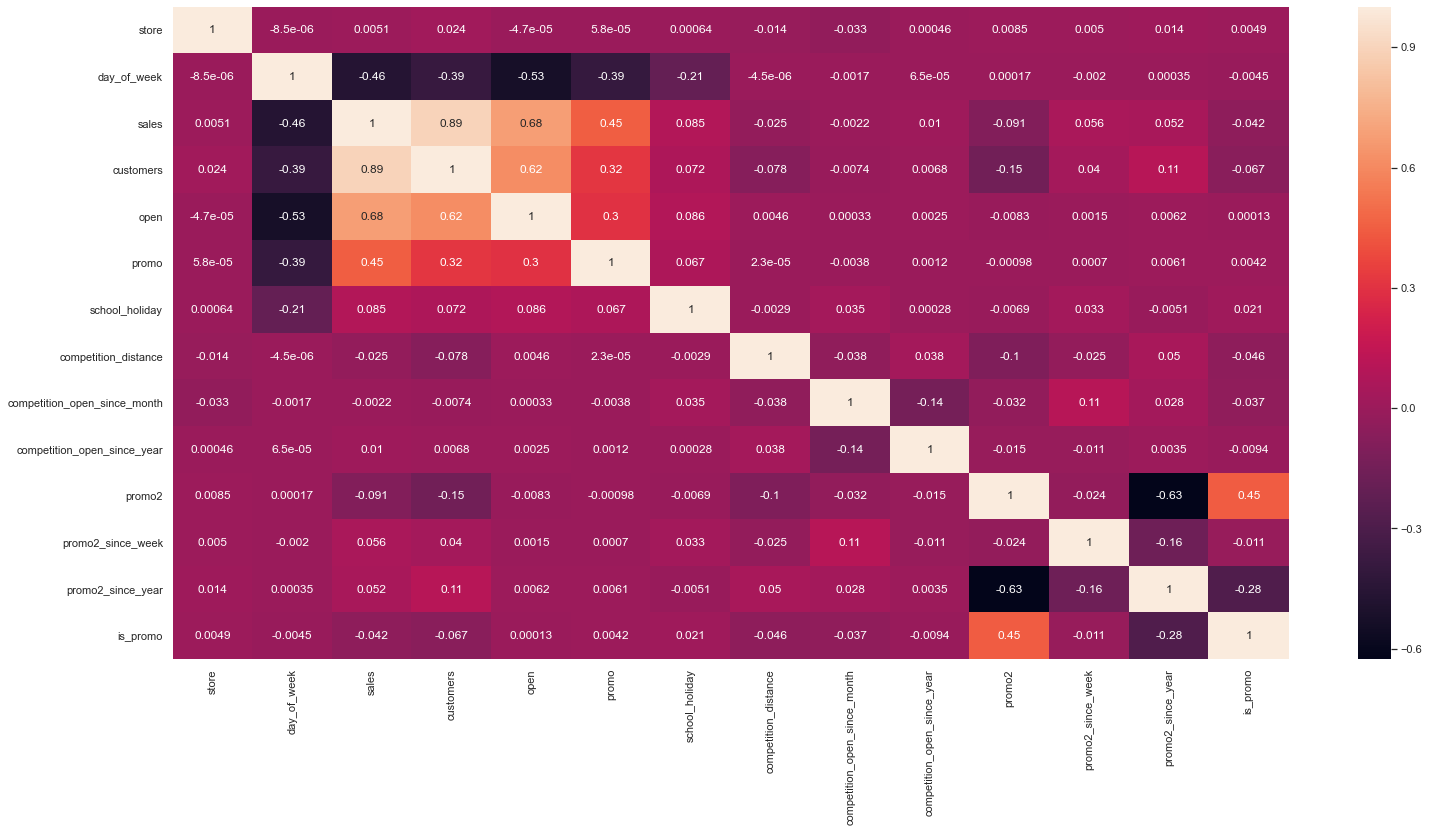

In [53]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.1 Categorical Attributes

In [54]:
#categorical data
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


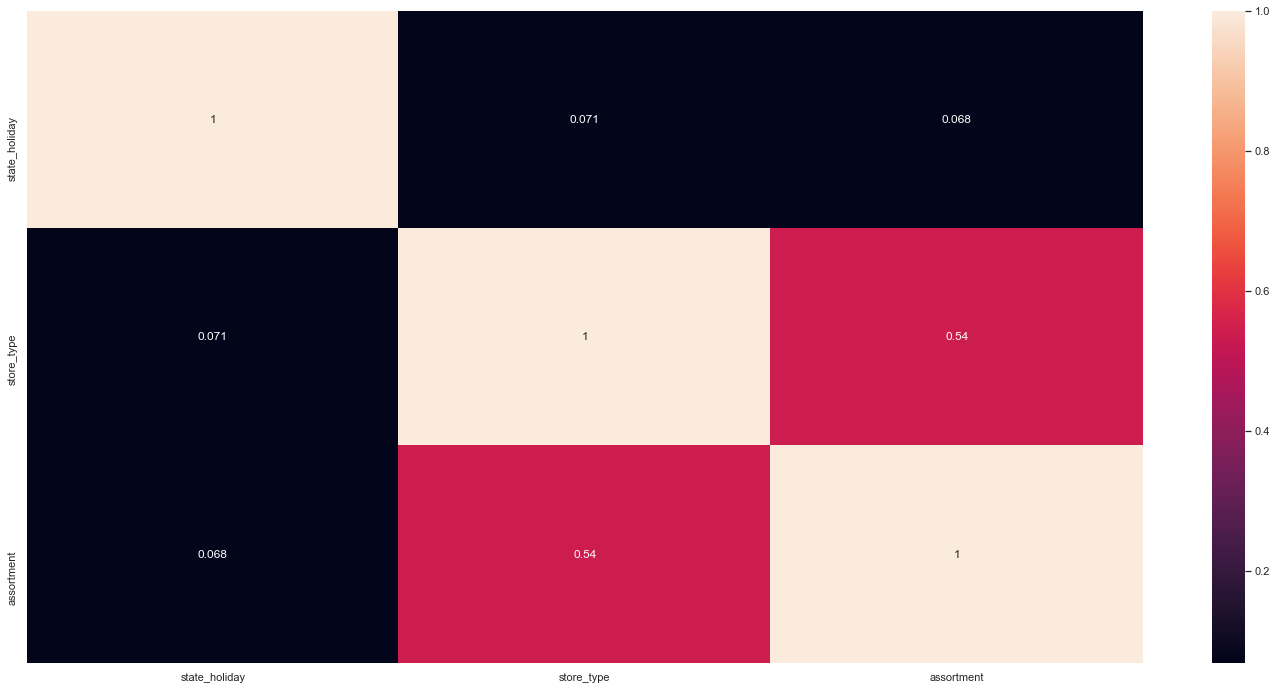

In [55]:
# calculate cramer v
a1 = cramer_v( a[ 'state_holiday'], a[ 'state_holiday' ] )
a2 = cramer_v( a[ 'state_holiday'], a[ 'store_type' ] )
a3 = cramer_v( a[ 'state_holiday'], a[ 'assortment' ] )

a4 = cramer_v( a[ 'store_type'], a[ 'state_holiday' ] )
a5 = cramer_v( a[ 'store_type'], a[ 'store_type' ] )
a6 = cramer_v( a[ 'store_type'], a[ 'assortment' ] )

a7 = cramer_v( a[ 'assortment'], a[ 'state_holiday' ] )
a8 = cramer_v( a[ 'assortment'], a[ 'store_type' ] )
a9 = cramer_v( a[ 'assortment'], a[ 'assortment' ] )

d = pd.DataFrame( { 'state_holiday' : [ a1, a2, a3 ], 
                'store_type' : [ a4, a5, a6 ], 
                'assortment' : [ a7, a8, a9 ]  } )

d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0 Data Preparation 

In [56]:
df5 = df4.copy()
df5.competition_time_month.dtypes


dtype('int64')

## 5.1 Normalizacao

In [57]:
# Normalização funciona melhor em variáveis normalmente distribuidas
# Verificando no EDA, não há nenhuma variável normalmente distribuida
# usaremos Rescaling

## 5.2 Rescaling

In [58]:
# Min-Max Scaler
# Robust Scaler (bom com outliers fortes)

a = df5.select_dtypes( include=[  'int64', 'float64' ] )

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5[ 'competition_distance'] = rs.fit_transform( df5[[ 'competition_distance' ]].values )

# competition_time_month
df5[ 'competition_time_month'] = rs.fit_transform( df5[[ 'competition_time_month' ]].values )

# promo_time_week
df5[ 'promo_time_week'] = mms.fit_transform( df5[[ 'promo_time_week' ]].values )

# year
df5[ 'year'] = mms.fit_transform( df5[[ 'year' ]].values )

## 5.3 Transformacao

### 5.3.1 Encoding

In [60]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5[ 'store_type' ] = le.fit_transform( df5[ 'store_type' ] )

# assortment - Ordinal Encoding
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df5[ 'assortment' ] = df5[ 'assortment' ].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [61]:
# log Transformation
df5[ 'sales' ] = np.log1p( df5[ 'sales' ] )

### 5.3.3 Nature Transformation

In [62]:
# month
df5[ 'month_sin' ] = df5[ 'month' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5[ 'month_cos' ] = df5[ 'month' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5[ 'day_sin' ] = df5[ 'day' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
df5[ 'day_cos' ] = df5[ 'day' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

# day_of_week
df5[ 'day_of_week_sin' ] = df5[ 'day_of_week' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
df5[ 'day_of_week_cos' ] = df5[ 'day_of_week' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

# week_of_year
df5[ 'week_of_year_sin' ] = df5[ 'week_of_year' ].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
df5[ 'week_of_year_cos' ] = df5[ 'week_of_year' ].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )

# 6.0 Feature Selection

In [63]:
df6 = df5.copy()

## 6.1 Split dataset into training and test dataset

In [64]:
# manter somente as colunas transformadas e excluir as anteriores
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [65]:
df6[[ 'store', 'date' ]].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [66]:
# training dataset
X_train = df6[ df6[ 'date' ] < '2015-06-19' ]
Y_train = X_train[ 'sales' ]

# test dataset
X_test = df6[ df6[ 'date' ] >= '2015-06-19' ]
Y_test = X_test[ 'sales' ]

print( 'Training Min Date: {}'.format( X_train[ 'date' ].min() ) )
print( 'Training Max Date: {}'.format( X_train[ 'date' ].max() ) )

print( '\nTest Min Date: {}'.format( X_test[ 'date' ].min() ) )
print( 'Test Max Date: {}'.format( X_test[ 'date' ].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [67]:
# training and test dataset for boruta
X_train_n = X_train.drop( [ 'date', 'sales' ], axis=1 ).values
Y_train_n = Y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n )

### 6.2.1 Best Features from Boruta

In [68]:

#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 );
#cols_selected_boruta =  X_train_fs.iloc[ :, cols_selected ].columns.tolist()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) ) # diferença entre os 2 conjuntos;

## 6.3 Manual Feature Selection

In [69]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = [ 'date', 'sales' ]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

cols_selected_boruta


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Machine Learning Modeling

In [70]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1 Average Model

In [71]:
aux1 = x_test.copy()
aux1[ 'sales' ] = Y_test.copy()

# predictions
aux2 = aux1[[ 'store', 'sales' ]].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales' : 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1[ 'predictions' ]

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result



,MODEL NAME,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [72]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,MODEL NAME,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


##### Obs: O erro RMSE do modelo linear é muito maior que o RMSE do modelo de média. Isso pode indicar uma possível natureza não linear nos dados, o que dificultaria modelagens de ordem linear como o Linear Regression.

### 7.2.1 Linear Regression Model - Cross Validation  

In [73]:
# entire dataset for cross validation
x_training = X_train[cols_selected_boruta_full]

In [74]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [75]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [76]:
# model
lrr = Lasso( alpha = 0.01 ).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,MODEL NAME,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation  

In [77]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )

In [78]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


## 7.4 Random Forest Regressor

In [84]:
# model
rf = RandomForestRegressor(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,MODEL NAME,MAE,MAPE,RMSE
0,Random Forest Regressor,678.390387,0.099764,1009.036722


### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )

In [85]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.52 +- 218.15,0.12 +- 0.02,1256.66 +- 319.24


## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             sub_sample=0.7, 
                             colsample_bytree=0.9 ).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [86]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [87]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1050.2 +- 184.08,0.14 +- 0.02,1515.79 +- 257.18


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [89]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_result.sort_values( 'RMSE' )

,MODEL NAME,MAE,MAPE,RMSE
0,Random Forest Regressor,678.390387,0.099764,1009.036722
0,XGBoost Regressor,876.739437,0.127568,1296.442372
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Performance - Cross Validation

In [91]:
modeling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26
0,Random Forest Regressor,837.52 +- 218.15,0.12 +- 0.02,1256.66 +- 319.24
0,XGBoost Regressor,1050.2 +- 184.08,0.14 +- 0.02,1515.79 +- 257.18
